In [349]:
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly as py
import plotly.offline as pyofftrain_test_split
import xgboost as xgb
from numpy import sort

#pyoff.init_notebook_mode()

import math

## Import data for inactivity calculation

In [350]:
customers = pd.read_csv('TMP_Inactivity.csv', sep = ';', decimal = ',')
customers = pd.read_csv('TMP_Inactivity_with_window.csv', sep = ';', decimal = ',')

In [351]:
customers.shape

(1880785, 11)

In [352]:
customers.head()

RECENCY  LP_DISTANCE2  LP_DISTANCE3  COUNT_RETURNS  CUSTOMER_SINCE_DAYS  \
0      6.0           1.0          11.0             10                 2244   
1     44.0          73.0          15.0              0                 2138   
2     11.0          45.0          27.0              0                 2201   
3      4.0          27.0          50.0              3                 2086   
4      8.0           3.0           8.0              2                 2208   

   DWH_CUSTOMER_ID  COUNT_TRX_DAYS  MAX_DATE_TIME_START  MIN_DATE_TIME_START  \
0                7             359  23.03.2020 00:00:00  30.01.2014 00:00:00   
1               10              31  09.03.2020 00:00:00  02.05.2014 00:00:00   
2               14             114  02.03.2020 00:00:00  21.02.2014 00:00:00   
3               22              64  30.11.2019 00:00:00  15.03.2014 00:00:00   
4               30             101  07.03.2020 00:00:00  19.02.2014 00:00:00   

       EXTRACTION_DATE         WINDOW_START  
0  26.03.2020 00:00:00  30.01.2014 00:00:00  
1  26.03.2020 00:00:00  30.01.2014 00:00:00  
2  26.03.2020 00:00:00  30.01.2014 00:00:00  
3  26.03.2020 00:00:00  30.01.2014 00:00:00  
4  26.03.2020 00:00:00  30.01.2014 00:00:00

In [353]:
# Variables distributions

for c in customers.columns:
    n = customers[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(customers[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

RECENCY
2067
----------
LP_DISTANCE2
1856
----------
LP_DISTANCE3
1701
----------
COUNT_RETURNS
206
----------
CUSTOMER_SINCE_DAYS
2248
----------
DWH_CUSTOMER_ID
1880785
----------
COUNT_TRX_DAYS
1140
----------
MAX_DATE_TIME_START
2103
----------
MIN_DATE_TIME_START
2135
----------
EXTRACTION_DATE
1 [('26.03.2020 00:00:00', 1880785)]
----------
WINDOW_START
1 [('30.01.2014 00:00:00', 1880785)]
----------


## Frequency

In [354]:
min(customers['CUSTOMER_SINCE_DAYS']), max(customers['CUSTOMER_SINCE_DAYS'])

#customers['CUSTOMER_SINCE_DAYS'] = 2 * customers['CUSTOMER_SINCE_DAYS'] # increases a little a number of neg. pred.
#customers['RECENCY'] = 2 * customers['RECENCY'] # increases a little a number of neg. pred.
#customers['COUNT_RETURNS'][customers['COUNT_RETURNS'] == 1] = 2 #then no negative predictions


(0, 2247)

In [355]:
%%time

customers['FREQUENCY']   = 365.25 * customers['COUNT_TRX_DAYS']/(np.maximum(30, customers['CUSTOMER_SINCE_DAYS']))
customers['AVG_RETURNS'] = 365.25 * customers['COUNT_RETURNS']/(np.maximum(30, customers['CUSTOMER_SINCE_DAYS']))


CPU times: user 19.5 ms, sys: 16 µs, total: 19.5 ms
Wall time: 19 ms


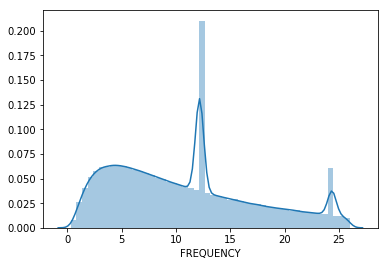

In [356]:
# There are peaks on the chart because frequency is via window calculated (min == 30 days). Short history: -> 12 (1 Monat/12)

sns.distplot(customers['FREQUENCY'][customers['FREQUENCY']<26])
plt.show()


In [357]:
customers.info()
customers.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880785 entries, 0 to 1880784
Data columns (total 13 columns):
RECENCY                float64
LP_DISTANCE2           float64
LP_DISTANCE3           float64
COUNT_RETURNS          int64
CUSTOMER_SINCE_DAYS    int64
DWH_CUSTOMER_ID        int64
COUNT_TRX_DAYS         int64
MAX_DATE_TIME_START    object
MIN_DATE_TIME_START    object
EXTRACTION_DATE        object
WINDOW_START           object
FREQUENCY              float64
AVG_RETURNS            float64
dtypes: float64(5), int64(4), object(4)
memory usage: 186.5+ MB


Index(['RECENCY', 'LP_DISTANCE2', 'LP_DISTANCE3', 'COUNT_RETURNS',
       'CUSTOMER_SINCE_DAYS', 'DWH_CUSTOMER_ID', 'COUNT_TRX_DAYS',
       'MAX_DATE_TIME_START', 'MIN_DATE_TIME_START', 'EXTRACTION_DATE',
       'WINDOW_START', 'FREQUENCY', 'AVG_RETURNS'],
      dtype='object')

Distribution of target variable and purchase distances are stable in time. 
Customers show the same behaviour over time

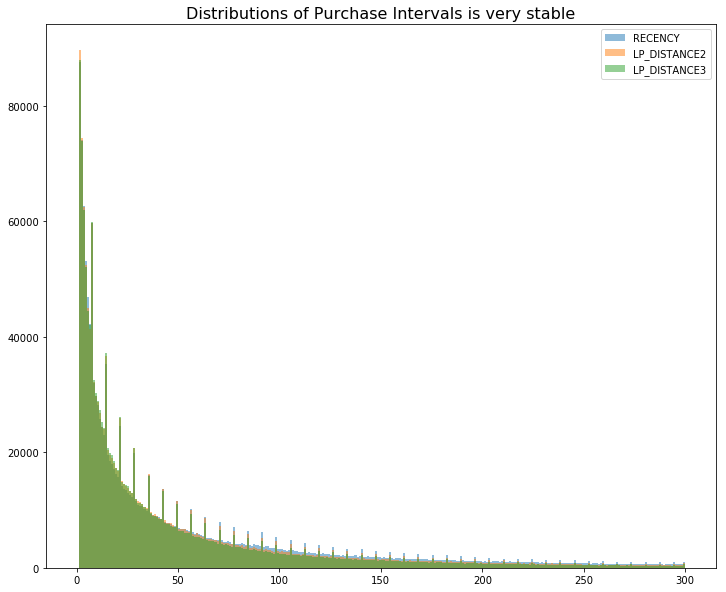

In [358]:
plt.rcParams['figure.figsize'] = (12,10)

plt.hist(customers['RECENCY'], bins = 300, range = [0, 300], alpha=0.5, label='RECENCY')
plt.hist(customers['LP_DISTANCE2'], bins = 300, range = [0, 300], alpha=0.5, label='LP_DISTANCE2')
plt.hist(customers['LP_DISTANCE3'], bins = 300, range = [0, 300], alpha=0.5, label='LP_DISTANCE3')
plt.title('Distributions of Purchase Intervals is very stable', fontsize=16)
plt.legend()
plt.show()

# Define "Common TRX Dataset" (> 1 TRX) 

In [359]:
customers_common = customers[customers['COUNT_TRX_DAYS'] > 1]

customers_null_TRX  = customers[customers['COUNT_TRX_DAYS'] ==0]
customers_single_TRX  = customers[customers['COUNT_TRX_DAYS'] == 1]
customers_two_TRX  = customers[customers['COUNT_TRX_DAYS'] == 2]
customers_three_TRX  = customers[customers['COUNT_TRX_DAYS'] == 3]
customers_four_TRX  = customers[customers['COUNT_TRX_DAYS'] == 4]

len(customers_common), len(customers_null_TRX), len(customers_single_TRX), len(customers_two_TRX), len(customers_three_TRX), len(customers_four_TRX) 

print(round(100 * len(customers_common) / len(customers), 2), "Percentage of customers with  > 1 TRX")
print(round(100 * len(customers_null_TRX) / len(customers), 2), "Percentage of customers with 0 TRX")
print(round(100 * len(customers_single_TRX) / len(customers), 2), "Percentage of customers with 1 TRX")
print(round(100 * len(customers_two_TRX) / len(customers), 2), "Percentage of customers with 2 TRX")   
print(round(100 * len(customers_three_TRX) / len(customers), 2), "Percentage of customers with 3 TRX") 
print(round(100 * len(customers_four_TRX) / len(customers), 2), "Percentage of customers with 4 TRX")  

#92.54 Percentage of customers with  > 1 TRX
#0.0 Percentage of customers with 0 TRX
#7.46 Percentage of customers with 1 TRX
#5.28 Percentage of customers with 2 TRX
#4.28 Percentage of customers with 3 TRX
#3.66 Percentage of customers with 4 TRX


92.27 Percentage of customers with  > 1 TRX
0.0 Percentage of customers with 0 TRX
7.73 Percentage of customers with 1 TRX
5.42 Percentage of customers with 2 TRX
4.38 Percentage of customers with 3 TRX
3.73 Percentage of customers with 4 TRX


## Customer Since Days

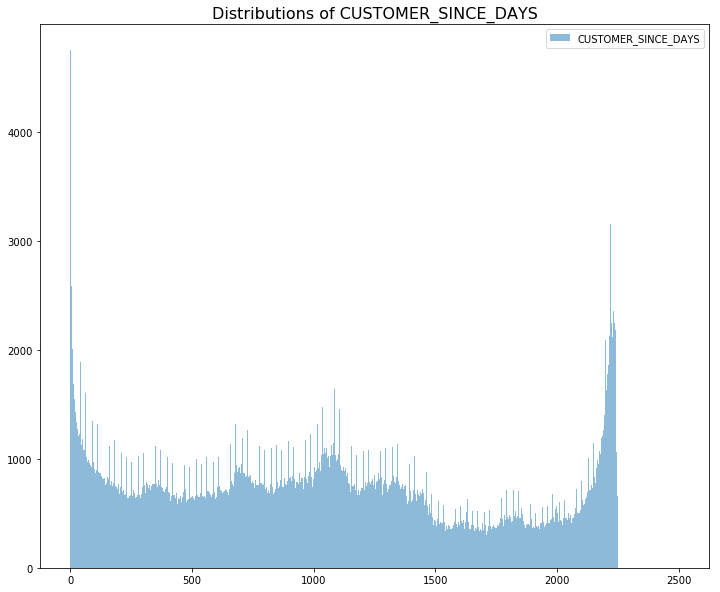

In [360]:
# Customers_since_days tend to smaller values, because data are aggregated by last purchase
# (for example 2 TRX in 2015 - just 1 day a customer by Toom)

plt.hist(customers_common['CUSTOMER_SINCE_DAYS'], bins = 2500, range = [0, 2500], alpha=0.5, label='CUSTOMER_SINCE_DAYS')
plt.title('Distributions of CUSTOMER_SINCE_DAYS', fontsize=16)
plt.legend()
plt.show()

In [361]:
print(customers_common['RECENCY'].isnull().value_counts())
print(customers_common['LP_DISTANCE2'].isnull().value_counts())
print(customers_common['LP_DISTANCE3'].isnull().value_counts()) 

False    1735314
Name: RECENCY, dtype: int64
False    1633417
True      101897
Name: LP_DISTANCE2, dtype: int64
False    1551089
True      184225
Name: LP_DISTANCE3, dtype: int64


Imputation for customers with only 2 and 3 Transactions. 
Null-LP_DISTANCE2 is replaced with their own RECENCY
Null-LP_DISTANCE3 is replaced with average from its own RECENCY and LP_DISTANCE2

In [362]:
customers_common

RECENCY  LP_DISTANCE2  LP_DISTANCE3  COUNT_RETURNS  \
0            6.0           1.0          11.0             10   
1           44.0          73.0          15.0              0   
2           11.0          45.0          27.0              0   
3            4.0          27.0          50.0              3   
4            8.0           3.0           8.0              2   
...          ...           ...           ...            ...   
1880737      2.0           NaN           NaN              0   
1880738    393.0           NaN           NaN              0   
1880739      2.0           NaN           NaN              0   
1880741      8.0           3.0           NaN              0   
1880742     66.0           NaN           NaN              0   

         CUSTOMER_SINCE_DAYS  DWH_CUSTOMER_ID  COUNT_TRX_DAYS  \
0                       2244                7             359   
1                       2138               10              31   
2                       2201               14             114   
3                       2086               22              64   
4                       2208               30             101   
...                      ...              ...             ...   
1880737                    2          2535886               2   
1880738                  393          2535887               2   
1880739                    2          2535888               2   
1880741                   11          2535893               3   
1880742                   66          2535895               2   

         MAX_DATE_TIME_START  MIN_DATE_TIME_START      EXTRACTION_DATE  \
0        23.03.2020 00:00:00  30.01.2014 00:00:00  26.03.2020 00:00:00   
1        09.03.2020 00:00:00  02.05.2014 00:00:00  26.03.2020 00:00:00   
2        02.03.2020 00:00:00  21.02.2014 00:00:00  26.03.2020 00:00:00   
3        30.11.2019 00:00:00  15.03.2014 00:00:00  26.03.2020 00:00:00   
4        07.03.2020 00:00:00  19.02.2014 00:00:00  26.03.2020 00:00:00   
...                      ...                  ...                  ...   
1880737  20.03.2020 00:00:00  18.03.2020 00:00:00  26.03.2020 00:00:00   
1880738  20.03.2020 00:00:00  21.02.2019 00:00:00  26.03.2020 00:00:00   
1880739  19.03.2020 00:00:00  17.03.2020 00:00:00  26.03.2020 00:00:00   
1880741  24.03.2020 00:00:00  13.03.2020 00:00:00  26.03.2020 00:00:00   
1880742  20.03.2020 00:00:00  14.01.2020 00:00:00  26.03.2020 00:00:00   

                WINDOW_START  FREQUENCY  AVG_RETURNS  
0        30.01.2014 00:00:00  58.433489     1.627674  
1        30.01.2014 00:00:00   5.295954     0.000000  
2        30.01.2014 00:00:00  18.917992     0.000000  
3        30.01.2014 00:00:00  11.206136     0.525288  
4        30.01.2014 00:00:00  16.707541     0.330842  
...                      ...        ...          ...  
1880737  30.01.2014 00:00:00  24.350000     0.000000  
1880738  30.01.2014 00:00:00   1.858779     0.000000  
1880739  30.01.2014 00:00:00  24.350000     0.000000  
1880741  30.01.2014 00:00:00  36.525000     0.000000  
1880742  30.01.2014 00:00:00  11.068182     0.000000  

[1735314 rows x 13 columns]

## Imputation

In [363]:
#as it was in a training set
#customers_common['LP_DISTANCE3'][customers_common['LP_DISTANCE3'].isnull()] = customers_common['LP_DISTANCE2']

customers_common['LP_DISTANCE2'][customers_common['LP_DISTANCE2'].isnull()] = customers_common['RECENCY']
customers_common['LP_DISTANCE3'][customers_common['LP_DISTANCE3'].isnull()] = 0.5 * (customers_common['LP_DISTANCE2'] + customers_common['RECENCY'])


In [364]:
customers_common

RECENCY  LP_DISTANCE2  LP_DISTANCE3  COUNT_RETURNS  \
0            6.0           1.0          11.0             10   
1           44.0          73.0          15.0              0   
2           11.0          45.0          27.0              0   
3            4.0          27.0          50.0              3   
4            8.0           3.0           8.0              2   
...          ...           ...           ...            ...   
1880737      2.0           2.0           2.0              0   
1880738    393.0         393.0         393.0              0   
1880739      2.0           2.0           2.0              0   
1880741      8.0           3.0           5.5              0   
1880742     66.0          66.0          66.0              0   

         CUSTOMER_SINCE_DAYS  DWH_CUSTOMER_ID  COUNT_TRX_DAYS  \
0                       2244                7             359   
1                       2138               10              31   
2                       2201               14             114   
3                       2086               22              64   
4                       2208               30             101   
...                      ...              ...             ...   
1880737                    2          2535886               2   
1880738                  393          2535887               2   
1880739                    2          2535888               2   
1880741                   11          2535893               3   
1880742                   66          2535895               2   

         MAX_DATE_TIME_START  MIN_DATE_TIME_START      EXTRACTION_DATE  \
0        23.03.2020 00:00:00  30.01.2014 00:00:00  26.03.2020 00:00:00   
1        09.03.2020 00:00:00  02.05.2014 00:00:00  26.03.2020 00:00:00   
2        02.03.2020 00:00:00  21.02.2014 00:00:00  26.03.2020 00:00:00   
3        30.11.2019 00:00:00  15.03.2014 00:00:00  26.03.2020 00:00:00   
4        07.03.2020 00:00:00  19.02.2014 00:00:00  26.03.2020 00:00:00   
...                      ...                  ...                  ...   
1880737  20.03.2020 00:00:00  18.03.2020 00:00:00  26.03.2020 00:00:00   
1880738  20.03.2020 00:00:00  21.02.2019 00:00:00  26.03.2020 00:00:00   
1880739  19.03.2020 00:00:00  17.03.2020 00:00:00  26.03.2020 00:00:00   
1880741  24.03.2020 00:00:00  13.03.2020 00:00:00  26.03.2020 00:00:00   
1880742  20.03.2020 00:00:00  14.01.2020 00:00:00  26.03.2020 00:00:00   

                WINDOW_START  FREQUENCY  AVG_RETURNS  
0        30.01.2014 00:00:00  58.433489     1.627674  
1        30.01.2014 00:00:00   5.295954     0.000000  
2        30.01.2014 00:00:00  18.917992     0.000000  
3        30.01.2014 00:00:00  11.206136     0.525288  
4        30.01.2014 00:00:00  16.707541     0.330842  
...                      ...        ...          ...  
1880737  30.01.2014 00:00:00  24.350000     0.000000  
1880738  30.01.2014 00:00:00   1.858779     0.000000  
1880739  30.01.2014 00:00:00  24.350000     0.000000  
1880741  30.01.2014 00:00:00  36.525000     0.000000  
1880742  30.01.2014 00:00:00  11.068182     0.000000  

[1735314 rows x 13 columns]

In [365]:
print(customers_common['RECENCY'].isnull().value_counts())
print(customers_common['LP_DISTANCE2'].isnull().value_counts())
print(customers_common['LP_DISTANCE3'].isnull().value_counts()) 

False    1735314
Name: RECENCY, dtype: int64
False    1735314
Name: LP_DISTANCE2, dtype: int64
False    1735314
Name: LP_DISTANCE3, dtype: int64


In [366]:
# Square Root function for time distances varaibles to normalize values

customers_common['RECENCY'] =  np.sqrt(customers_common['RECENCY'])
customers_common['LP_DISTANCE2'] =  np.sqrt(customers_common['LP_DISTANCE2'])
customers_common['LP_DISTANCE3'] =  np.sqrt(customers_common['LP_DISTANCE3'])


In [367]:
print(min(customers_common['RECENCY']), max(customers_common['RECENCY']))
print(min(customers_common['LP_DISTANCE2']), max(customers_common['LP_DISTANCE2']))
print(min(customers_common['LP_DISTANCE3']), max(customers_common['LP_DISTANCE3']))

print(min(customers_common['FREQUENCY']), max(customers_common['FREQUENCY']))
print(min(customers_common['AVG_RETURNS']), max(customers_common['AVG_RETURNS']))

print(min(customers_common['CUSTOMER_SINCE_DAYS']), max(customers_common['CUSTOMER_SINCE_DAYS']))

1.0 47.22287581247038
1.0 47.22287581247038
1.0 47.22287581247038
0.3275784753363229 278.2857142857143
0.0 102.91484618814088
1 2247


In [368]:
# Instead of dropping, we will take only 5 necessary features

In [369]:
customers_common = customers_common[['RECENCY', 'LP_DISTANCE2', 'LP_DISTANCE3', 'FREQUENCY', 'AVG_RETURNS']]
customers_common

RECENCY  LP_DISTANCE2  LP_DISTANCE3  FREQUENCY  AVG_RETURNS
0         2.449490      1.000000      3.316625  58.433489     1.627674
1         6.633250      8.544004      3.872983   5.295954     0.000000
2         3.316625      6.708204      5.196152  18.917992     0.000000
3         2.000000      5.196152      7.071068  11.206136     0.525288
4         2.828427      1.732051      2.828427  16.707541     0.330842
...            ...           ...           ...        ...          ...
1880737   1.414214      1.414214      1.414214  24.350000     0.000000
1880738  19.824228     19.824228     19.824228   1.858779     0.000000
1880739   1.414214      1.414214      1.414214  24.350000     0.000000
1880741   2.828427      1.732051      2.345208  36.525000     0.000000
1880742   8.124038      8.124038      8.124038  11.068182     0.000000

[1735314 rows x 5 columns]

In [370]:
print(np.mean(customers_common['RECENCY']))
print(np.mean(customers_common['LP_DISTANCE2']))
print(np.mean(customers_common['LP_DISTANCE3']))
print(np.mean(customers_common['FREQUENCY']))
print(np.mean(customers_common['AVG_RETURNS']))

7.252879256972199
6.718058185664612
6.524903791164959
14.97636029846223
0.8658045432432825


## Make predictions with a model and best hyperparameters found during the Inactivity analysis

In [371]:
#?booster

In [372]:
%%time

booster = xgb.Booster()

booster.load_model('activity.model')


CPU times: user 968 µs, sys: 0 ns, total: 968 µs
Wall time: 750 µs


In [373]:
#y_pred = booster.predict(customers_common)

y_pred = booster.predict(xgb.DMatrix(customers_common))


In [374]:
print(len(y_pred))
print(type(y_pred[0]))
min(y_pred), max(y_pred), min(y_pred**2), max(y_pred**2)
#y_pred


1735314
<class 'numpy.float32'>


(-0.5339954, 13.571182, 0.0003671868, 184.17699)

In [375]:
# no negative predictions

display(y_pred[y_pred < 0])
len(y_pred[y_pred < 0]) # 3 neg.predictions

array([-0.4563977 , -0.5339954 , -0.24528319], dtype=float32)

3

In [376]:

customers_copy = customers[customers['COUNT_TRX_DAYS'] > 1]
len(customers_copy)
#np.mean(customers_common['FREQUENCY'])

1735314

## Dependency of prediction on main features

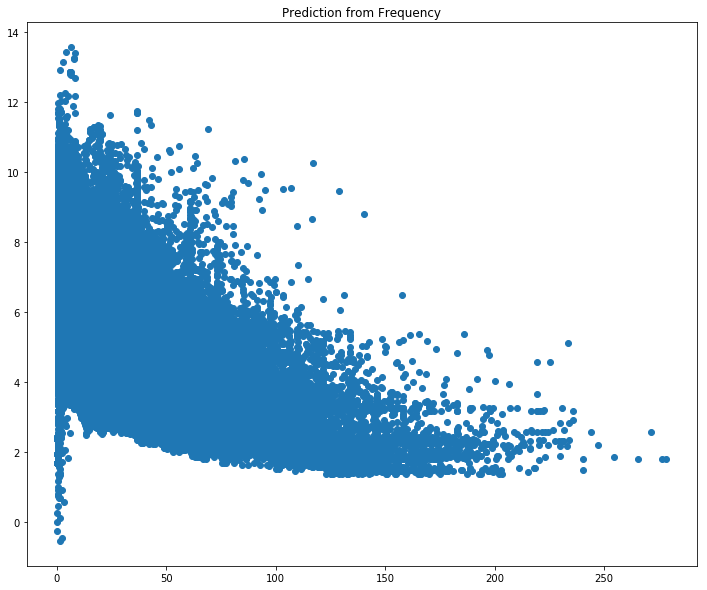

In [377]:
plt.scatter(customers_common['FREQUENCY'], y_pred)
plt.title('Prediction from Frequency')
plt.show()

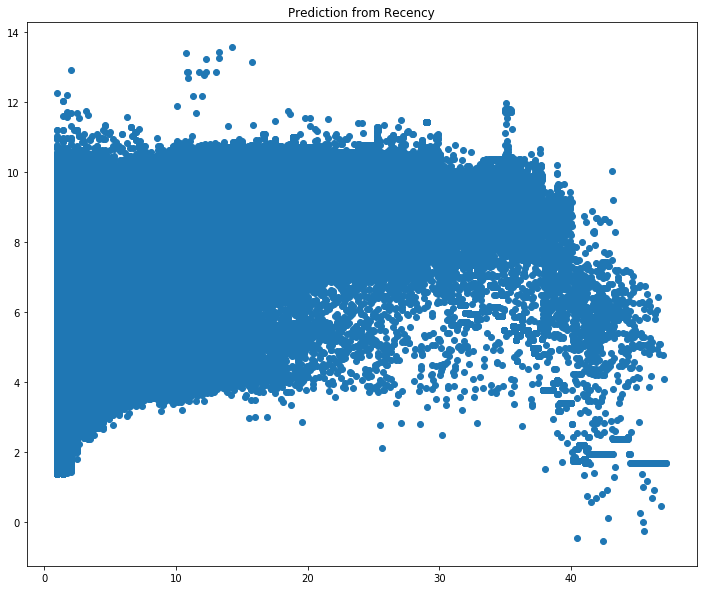

In [378]:
plt.scatter(customers_common['RECENCY'], y_pred)
plt.title('Prediction from Recency')
plt.show()

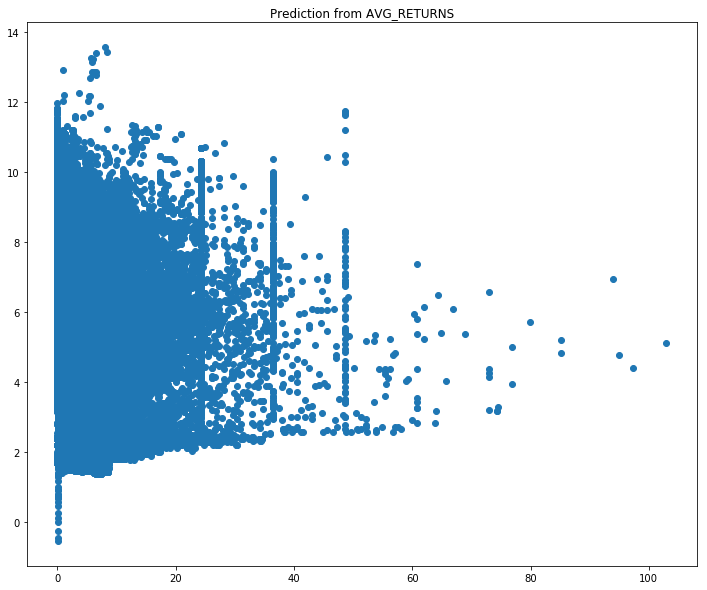

In [379]:
#24, 36, 48 because of normalisation min(30, CUSTOMER_SINCE_DAYS)

plt.scatter(customers_common['AVG_RETURNS'], y_pred)
plt.title('Prediction from AVG_RETURNS')
plt.show()

# Results

In [380]:
# Square values again

# predictions
y_pred = y_pred ** 2
y_pred

array([ 7.9143357, 67.02045  , 42.59991  , ..., 17.383179 , 48.644943 ,
       67.72978  ], dtype=float32)

In [381]:
np.mean(y_pred)  

# 53.7446    CMPG1341
# 51.383816  CMPG1391
# 51.373140  CMPG1484
# 51.735775  CMPG1498


51.988247

## Pareto

In [382]:
# We choose constant = 0.01 and power = 2 for simplicity, mae is one of the smallest

y_pred_pareto_simulation = 0.01 * y_pred**2

#y_pred_pareto_simulation = 0.025 * y_pred**1.8
y_pred_pareto_simulation = np.maximum(1, np.round(y_pred_pareto_simulation, 0).astype(int))

In [383]:
np.mean(y_pred_pareto_simulation)

34.752765781870025

In [384]:
# We stretched a prediction range by Pareto Simulation

min(y_pred_pareto_simulation), max(y_pred_pareto_simulation) 

(1, 339)

In [385]:
# After y_pred_pareto_simulation is calculated, we can make y_pred the integer type!

y_pred = np.maximum(1, np.round(y_pred, 0).astype(int))

In [386]:
# Prediction range is much narrower than in a case of Pareto

print(min(y_pred))
print(max(y_pred))
print(min(y_pred_pareto_simulation))
print(max(y_pred_pareto_simulation))

1
184
1
339


In [387]:
# Copy of a dataframe to take time characteristics

#customers_copy = customers[customers['COUNT_TRX_DAYS'] > 1]
#len(customers_copy)

In [388]:
# Create a dataframe with predicted, pareto values and all other time parameters

dataset = pd.DataFrame({'predicted': y_pred, 'pareto': y_pred_pareto_simulation, 'recency': customers_copy['RECENCY'], 'lp_distance2': customers_copy['LP_DISTANCE2'], 'lp_distance3': customers_copy['LP_DISTANCE3']}, columns=['predicted', 'pareto', 'recency', 'lp_distance2', 'lp_distance3'])

dataset.head(10)

predicted  pareto  recency  lp_distance2  lp_distance3
0           8       1      6.0           1.0          11.0
1          67      45     44.0          73.0          15.0
2          43      18     11.0          45.0          27.0
3          34      11      4.0          27.0          50.0
4          15       2      8.0           3.0           8.0
6          36      13     10.0          12.0         295.0
7          91      83     72.0          59.0          74.0
8          10       1      4.0           3.0           6.0
9         115     132    366.0           NaN           NaN
10         41      17      7.0           5.0          79.0

In [389]:
# Check the occurence of all time parameters

pd.concat([dataset.predicted.value_counts(), dataset.pareto.value_counts(), dataset.recency.value_counts(), dataset.lp_distance2.value_counts(), dataset.lp_distance3.value_counts()], axis=1).head(15)


predicted   pareto  recency  lp_distance2  lp_distance3
1.0        16.0  76425.0  87688.0       89698.0       88044.0
2.0       368.0  60682.0  74142.0       74472.0       73860.0
3.0      1113.0  66164.0  62701.0       62575.0       61968.0
4.0      1988.0  53830.0  53149.0       52508.0       52146.0
5.0      3227.0  46086.0  46969.0       44971.0       44561.0
6.0      4831.0  49354.0  42205.0       41421.0       42138.0
7.0      6400.0  44956.0  59685.0       59728.0       59999.0
8.0      9291.0  38135.0  32095.0       32147.0       32543.0
9.0     10215.0  36854.0  29812.0       29699.0       30313.0
10.0    13958.0  35374.0  28142.0       28688.0       28978.0
11.0    13663.0  36967.0  25701.0       26852.0       27402.0
12.0    15237.0  33793.0  24439.0       24469.0       25212.0
13.0    15884.0  31869.0  23061.0       24043.0       24190.0
14.0    17127.0  31185.0  35273.0       36764.0       37225.0
15.0    18168.0  29329.0  19593.0       20369.0       20788.0

## Comparison of Predicted and Pareto values

No handles with labels found to put in legend.


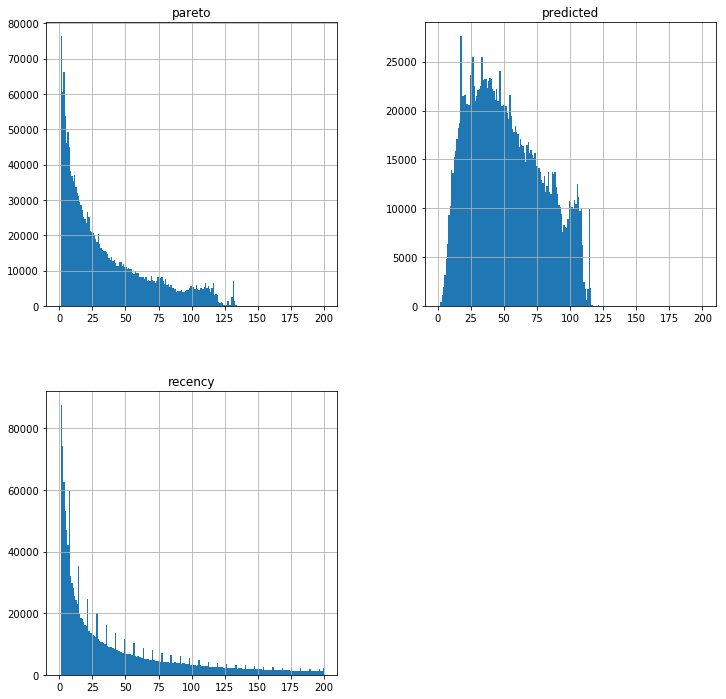

<Figure size 864x864 with 0 Axes>

In [390]:
#dataset = dataset_karenz

# Switched chart - correct!!!

plt.rcParams['figure.figsize'] = (12,12)

#dataset[['pareto', 'predicted']].hist(range = [0, 200], bins=200)
#dataset[['pareto', 'recency']].hist(range = [0, 200], bins=200)
#dataset[['recency', 'predicted']].hist(range = [0, 200], bins=200)

dataset[['recency', 'predicted', 'pareto']].hist(range = [0, 200], bins=200)

plt.legend(loc='upper right')


fig = plt.figure()
#plt.ylabel('Number of predictions', fontsize=16)
#plt.xlabel('Days', fontsize=16)

#from pylab import *
#fig = gcf()
fig.suptitle('Distributions of predicted and pareto values', fontsize=16)
#fig.suplable('Days')

#fig = plt.figure()
#ax = fig.add_subplot(121) 
#ax.set_xlabel('Days', fontsize=16)
#ax.set_ylabel('Number of predictions', fontsize=16)

plt.show()


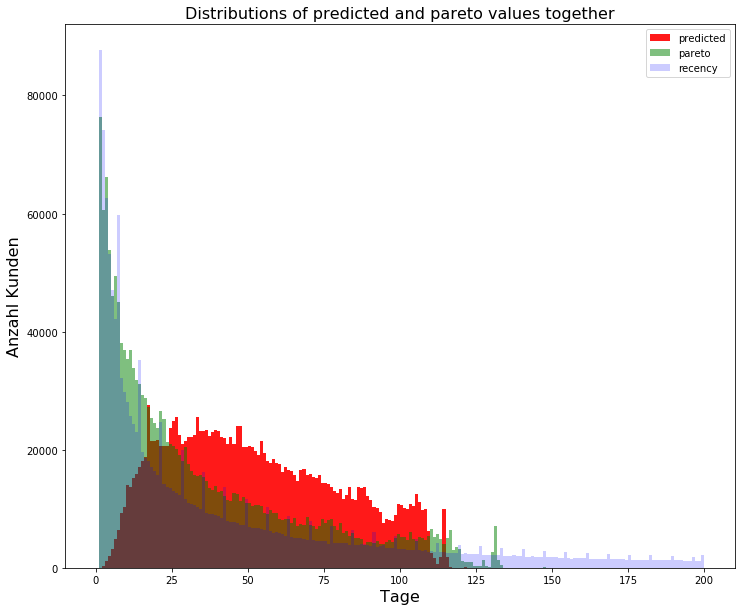

In [391]:
#dataset = dataset_karenz


plt.rcParams['figure.figsize'] = (12,10)

plt.hist(dataset.predicted, bins = 200, range = [0, 200], alpha=0.9, label='predicted', color = 'red')
plt.hist(dataset.pareto, bins = 200, range = [0, 200], alpha=0.5, label='pareto', color = 'g')
plt.hist(dataset.recency, bins = 200, range = [0, 200], alpha=0.2, label='recency', color = 'blue')

#plt.hist(dataset.Karenz_Simulation, bins = 100, range = [0, 500], alpha=0.6, label='predicted')
plt.legend(loc='upper right')

plt.title('Distributions of predicted and pareto values together', fontsize=16)

plt.ylabel('Anzahl Kunden', fontsize=16)
plt.xlabel('Tage', fontsize=16)

plt.show()

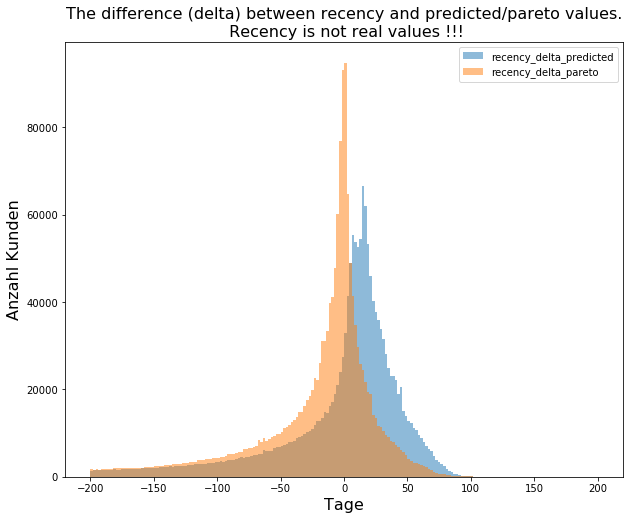

In [392]:
# Forecast delta: The narrower the better

plt.rcParams['figure.figsize'] = (10,8)
plt.hist(dataset.predicted-dataset.recency, bins = 200, range = [-200, 200], alpha=0.5, label='recency_delta_predicted')
plt.hist(dataset.pareto-dataset.recency, bins = 200, range = [-200, 200], alpha=0.5, label='recency_delta_pareto')

plt.legend(loc='upper right')

plt.title('The difference (delta) between recency and predicted/pareto values.' + 
          '\n Recency is not real values !!!'
          , fontsize=16)

plt.ylabel('Anzahl Kunden', fontsize=16)
plt.xlabel('Tage', fontsize=16)

plt.show()

In [393]:
y_pred_pareto_simulation = dataset.pareto

inactivity_in_days = np.sqrt((2 * y_pred_pareto_simulation)**2 + 30**2) + 40*np.sin(np.tanh(y_pred_pareto_simulation/50)*math.pi)
#inactivity_in_days = np.sqrt((2 * y_pred_pareto_simulation)**2 + 30**2)


len(inactivity_in_days)

np.percentile(y_pred_pareto_simulation, 99)

100 * len(y_pred_pareto_simulation[y_pred_pareto_simulation >= 150])/len(y_pred_pareto_simulation)

#100 * len(inactivity_in_days[inactivity_in_days >= 365/2])/len(inactivity_in_days) # ca. 1%

#100 * len(inactivity_in_days[inactivity_in_days >= np.percentile(inactivity_in_days, 99)])/len(inactivity_in_days)


0.00996937730001602

In [394]:
np.mean(inactivity_in_days)

102.63714875380448

In [395]:
# Take final predictions, join with initial table and find who was inactive to the begginning of a Campaign

len(inactivity_in_days)  # 1.029.668

customers_final = customers[customers['COUNT_TRX_DAYS'] > 1]

# Filter Campaign
#filter = (pd.to_datetime(customers_final['START_DATE']) == campaign_start)   
#filter = (pd.to_datetime(customers_final['END_DATE']) == campaign_end)   

#customers_final = customers_final[filter]

customers_final['inactivity_in_days'] = round(inactivity_in_days, 0)
customers_final

RECENCY  LP_DISTANCE2  LP_DISTANCE3  COUNT_RETURNS  \
0            6.0           1.0          11.0             10   
1           44.0          73.0          15.0              0   
2           11.0          45.0          27.0              0   
3            4.0          27.0          50.0              3   
4            8.0           3.0           8.0              2   
...          ...           ...           ...            ...   
1880737      2.0           NaN           NaN              0   
1880738    393.0           NaN           NaN              0   
1880739      2.0           NaN           NaN              0   
1880741      8.0           3.0           NaN              0   
1880742     66.0           NaN           NaN              0   

         CUSTOMER_SINCE_DAYS  DWH_CUSTOMER_ID  COUNT_TRX_DAYS  \
0                       2244                7             359   
1                       2138               10              31   
2                       2201               14             114   
3                       2086               22              64   
4                       2208               30             101   
...                      ...              ...             ...   
1880737                    2          2535886               2   
1880738                  393          2535887               2   
1880739                    2          2535888               2   
1880741                   11          2535893               3   
1880742                   66          2535895               2   

         MAX_DATE_TIME_START  MIN_DATE_TIME_START      EXTRACTION_DATE  \
0        23.03.2020 00:00:00  30.01.2014 00:00:00  26.03.2020 00:00:00   
1        09.03.2020 00:00:00  02.05.2014 00:00:00  26.03.2020 00:00:00   
2        02.03.2020 00:00:00  21.02.2014 00:00:00  26.03.2020 00:00:00   
3        30.11.2019 00:00:00  15.03.2014 00:00:00  26.03.2020 00:00:00   
4        07.03.2020 00:00:00  19.02.2014 00:00:00  26.03.2020 00:00:00   
...                      ...                  ...                  ...   
1880737  20.03.2020 00:00:00  18.03.2020 00:00:00  26.03.2020 00:00:00   
1880738  20.03.2020 00:00:00  21.02.2019 00:00:00  26.03.2020 00:00:00   
1880739  19.03.2020 00:00:00  17.03.2020 00:00:00  26.03.2020 00:00:00   
1880741  24.03.2020 00:00:00  13.03.2020 00:00:00  26.03.2020 00:00:00   
1880742  20.03.2020 00:00:00  14.01.2020 00:00:00  26.03.2020 00:00:00   

                WINDOW_START  FREQUENCY  AVG_RETURNS  inactivity_in_days  
0        30.01.2014 00:00:00  58.433489     1.627674                33.0  
1        30.01.2014 00:00:00   5.295954     0.000000               126.0  
2        30.01.2014 00:00:00  18.917992     0.000000                82.0  
3        30.01.2014 00:00:00  11.206136     0.525288                62.0  
4        30.01.2014 00:00:00  16.707541     0.330842                35.0  
...                      ...        ...          ...                 ...  
1880737  30.01.2014 00:00:00  24.350000     0.000000                38.0  
1880738  30.01.2014 00:00:00   1.858779     0.000000               257.0  
1880739  30.01.2014 00:00:00  24.350000     0.000000                38.0  
1880741  30.01.2014 00:00:00  36.525000     0.000000                96.0  
1880742  30.01.2014 00:00:00  11.068182     0.000000               127.0  

[1735314 rows x 14 columns]

## We should limit a maximal date by 365 days!

In [396]:
min(customers_final['inactivity_in_days']), max(customers_final['inactivity_in_days']) # up to ca. 1000 days

len(customers_final[customers_final['inactivity_in_days'] > 365]) # 21 such customers for Campaign 1341 

customers_final['inactivity_in_days'][customers_final['inactivity_in_days'] > 365] = 365  # only 53

In [397]:
customers_final['inactivity_date'] = pd.to_datetime(customers_final['MAX_DATE_TIME_START'], dayfirst=True) + pd.TimedeltaIndex(customers_final['inactivity_in_days'], unit='D')

customers_final['inactivity_date'] = pd.to_datetime(customers_final['inactivity_date'])

customers_final

RECENCY  LP_DISTANCE2  LP_DISTANCE3  COUNT_RETURNS  \
0            6.0           1.0          11.0             10   
1           44.0          73.0          15.0              0   
2           11.0          45.0          27.0              0   
3            4.0          27.0          50.0              3   
4            8.0           3.0           8.0              2   
...          ...           ...           ...            ...   
1880737      2.0           NaN           NaN              0   
1880738    393.0           NaN           NaN              0   
1880739      2.0           NaN           NaN              0   
1880741      8.0           3.0           NaN              0   
1880742     66.0           NaN           NaN              0   

         CUSTOMER_SINCE_DAYS  DWH_CUSTOMER_ID  COUNT_TRX_DAYS  \
0                       2244                7             359   
1                       2138               10              31   
2                       2201               14             114   
3                       2086               22              64   
4                       2208               30             101   
...                      ...              ...             ...   
1880737                    2          2535886               2   
1880738                  393          2535887               2   
1880739                    2          2535888               2   
1880741                   11          2535893               3   
1880742                   66          2535895               2   

         MAX_DATE_TIME_START  MIN_DATE_TIME_START      EXTRACTION_DATE  \
0        23.03.2020 00:00:00  30.01.2014 00:00:00  26.03.2020 00:00:00   
1        09.03.2020 00:00:00  02.05.2014 00:00:00  26.03.2020 00:00:00   
2        02.03.2020 00:00:00  21.02.2014 00:00:00  26.03.2020 00:00:00   
3        30.11.2019 00:00:00  15.03.2014 00:00:00  26.03.2020 00:00:00   
4        07.03.2020 00:00:00  19.02.2014 00:00:00  26.03.2020 00:00:00   
...                      ...                  ...                  ...   
1880737  20.03.2020 00:00:00  18.03.2020 00:00:00  26.03.2020 00:00:00   
1880738  20.03.2020 00:00:00  21.02.2019 00:00:00  26.03.2020 00:00:00   
1880739  19.03.2020 00:00:00  17.03.2020 00:00:00  26.03.2020 00:00:00   
1880741  24.03.2020 00:00:00  13.03.2020 00:00:00  26.03.2020 00:00:00   
1880742  20.03.2020 00:00:00  14.01.2020 00:00:00  26.03.2020 00:00:00   

                WINDOW_START  FREQUENCY  AVG_RETURNS  inactivity_in_days  \
0        30.01.2014 00:00:00  58.433489     1.627674                33.0   
1        30.01.2014 00:00:00   5.295954     0.000000               126.0   
2        30.01.2014 00:00:00  18.917992     0.000000                82.0   
3        30.01.2014 00:00:00  11.206136     0.525288                62.0   
4        30.01.2014 00:00:00  16.707541     0.330842                35.0   
...                      ...        ...          ...                 ...   
1880737  30.01.2014 00:00:00  24.350000     0.000000                38.0   
1880738  30.01.2014 00:00:00   1.858779     0.000000               257.0   
1880739  30.01.2014 00:00:00  24.350000     0.000000                38.0   
1880741  30.01.2014 00:00:00  36.525000     0.000000                96.0   
1880742  30.01.2014 00:00:00  11.068182     0.000000               127.0   

        inactivity_date  
0            2020-04-25  
1            2020-07-13  
2            2020-05-23  
3            2020-01-31  
4            2020-04-11  
...                 ...  
1880737      2020-04-27  
1880738      2020-12-02  
1880739      2020-04-26  
1880741      2020-06-28  
1880742      2020-07-25  

[1735314 rows x 15 columns]

In [398]:
100 * len(customers_final[customers_final['inactivity_date'] <= pd.to_datetime(customers_final['EXTRACTION_DATE'])])/len(customers_final)

#46% are inactive (44.7% with windows)


44.71444361078168

## Set the inactivity flag

In [399]:
customers_final['inactivity_flag'] = np.where(customers_final['inactivity_date'] <= pd.to_datetime(customers_final['EXTRACTION_DATE']), 1, 0)
customers_final 


RECENCY  LP_DISTANCE2  LP_DISTANCE3  COUNT_RETURNS  \
0            6.0           1.0          11.0             10   
1           44.0          73.0          15.0              0   
2           11.0          45.0          27.0              0   
3            4.0          27.0          50.0              3   
4            8.0           3.0           8.0              2   
...          ...           ...           ...            ...   
1880737      2.0           NaN           NaN              0   
1880738    393.0           NaN           NaN              0   
1880739      2.0           NaN           NaN              0   
1880741      8.0           3.0           NaN              0   
1880742     66.0           NaN           NaN              0   

         CUSTOMER_SINCE_DAYS  DWH_CUSTOMER_ID  COUNT_TRX_DAYS  \
0                       2244                7             359   
1                       2138               10              31   
2                       2201               14             114   
3                       2086               22              64   
4                       2208               30             101   
...                      ...              ...             ...   
1880737                    2          2535886               2   
1880738                  393          2535887               2   
1880739                    2          2535888               2   
1880741                   11          2535893               3   
1880742                   66          2535895               2   

         MAX_DATE_TIME_START  MIN_DATE_TIME_START      EXTRACTION_DATE  \
0        23.03.2020 00:00:00  30.01.2014 00:00:00  26.03.2020 00:00:00   
1        09.03.2020 00:00:00  02.05.2014 00:00:00  26.03.2020 00:00:00   
2        02.03.2020 00:00:00  21.02.2014 00:00:00  26.03.2020 00:00:00   
3        30.11.2019 00:00:00  15.03.2014 00:00:00  26.03.2020 00:00:00   
4        07.03.2020 00:00:00  19.02.2014 00:00:00  26.03.2020 00:00:00   
...                      ...                  ...                  ...   
1880737  20.03.2020 00:00:00  18.03.2020 00:00:00  26.03.2020 00:00:00   
1880738  20.03.2020 00:00:00  21.02.2019 00:00:00  26.03.2020 00:00:00   
1880739  19.03.2020 00:00:00  17.03.2020 00:00:00  26.03.2020 00:00:00   
1880741  24.03.2020 00:00:00  13.03.2020 00:00:00  26.03.2020 00:00:00   
1880742  20.03.2020 00:00:00  14.01.2020 00:00:00  26.03.2020 00:00:00   

                WINDOW_START  FREQUENCY  AVG_RETURNS  inactivity_in_days  \
0        30.01.2014 00:00:00  58.433489     1.627674                33.0   
1        30.01.2014 00:00:00   5.295954     0.000000               126.0   
2        30.01.2014 00:00:00  18.917992     0.000000                82.0   
3        30.01.2014 00:00:00  11.206136     0.525288                62.0   
4        30.01.2014 00:00:00  16.707541     0.330842                35.0   
...                      ...        ...          ...                 ...   
1880737  30.01.2014 00:00:00  24.350000     0.000000                38.0   
1880738  30.01.2014 00:00:00   1.858779     0.000000               257.0   
1880739  30.01.2014 00:00:00  24.350000     0.000000                38.0   
1880741  30.01.2014 00:00:00  36.525000     0.000000                96.0   
1880742  30.01.2014 00:00:00  11.068182     0.000000               127.0   

        inactivity_date  inactivity_flag  
0            2020-04-25                0  
1            2020-07-13                0  
2            2020-05-23                0  
3            2020-01-31                1  
4            2020-04-11                0  
...                 ...              ...  
1880737      2020-04-27                0  
1880738      2020-12-02                0  
1880739      2020-04-26                0  
1880741      2020-06-28                0  
1880742      2020-07-25                0  

[1735314 rows x 16 columns]

In [400]:
customers_final['inactivity_flag'].value_counts()

0    959378
1    775936
Name: inactivity_flag, dtype: int64

## Inactivity distribution

In [420]:
# Extraction_date = 26.03.2020

type(customers_final['inactivity_date'][0]), type(customers_final['EXTRACTION_DATE'][0])

#44.45% are inactive already to extraction date
100 * len(customers_final[customers_final['inactivity_date'] < pd.to_datetime(customers_final['EXTRACTION_DATE'])])/len(customers_final)



44.451436454728075

In [505]:

inactive_distribution = customers_final['inactivity_date'].value_counts().sort_index()
inactive_distribution_since_extraction = inactive_distribution[inactive_distribution.index >= customers_final['EXTRACTION_DATE'][0]]

inactive_distribution_share = 100 * inactive_distribution / sum(inactive_distribution) 
inactive_distribution_since_extraction_share = 100 * inactive_distribution_since_extraction / sum(inactive_distribution_since_extraction)

inactive_distribution
inactive_distribution_since_extraction

inactive_distribution.sort_values(ascending = False).head(10) # ca. 100 Thousand per week
inactive_distribution_since_extraction.sort_values(ascending = False).head(10)


#inactive_distribution_share
#inactive_distribution_since_extraction_share

2020-04-28    23779
2020-04-27    22283
2020-04-23    21369
2020-04-25    19873
2020-04-30    17864
2020-04-22    16635
2020-04-26    15997
2020-04-21    15363
2020-05-03    14904
2020-04-24    14662
Name: inactivity_date, dtype: int64

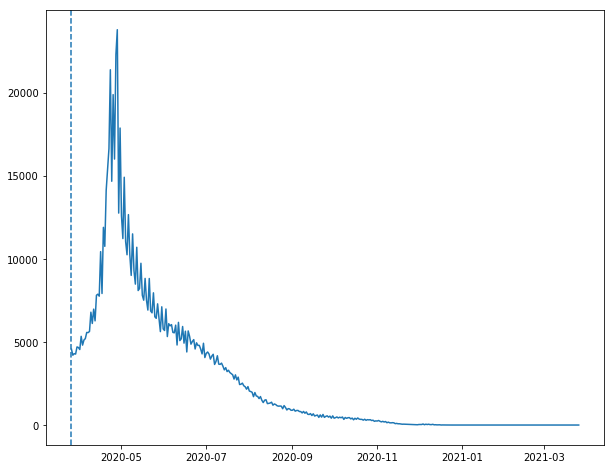

In [512]:
# Absolute Values
#plt.plot(inactive_distribution.index, inactive_distribution.values)
plt.plot(inactive_distribution_since_extraction.index, inactive_distribution_since_extraction.values)

# Percentage Values
#plt.plot(inactive_distribution_share.index, inactive_distribution_share.values)
#plt.plot(inactive_distribution_since_extraction_share.index, inactive_distribution_since_extraction_share.values)

#plt.xlim([customers_final['EXTRACTION_DATE'][0], inactive_distribution.index[-1]])
#plt.ylim([-1, 200])

plt.axvline(x=customers_final['EXTRACTION_DATE'][0], linestyle='--')

plt.show()

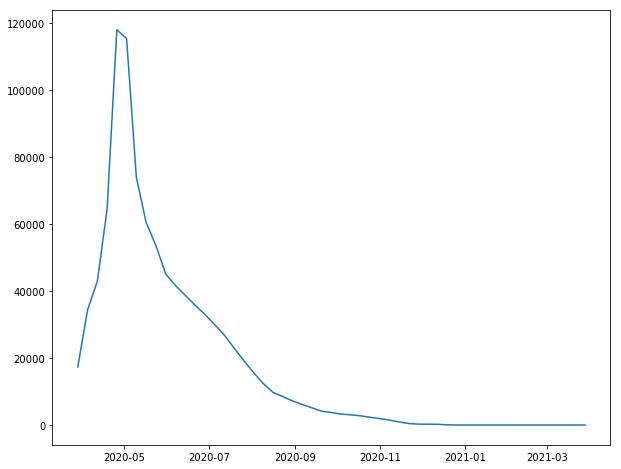

In [507]:
# Histogram on a week basis

inactive_distribution_since_extraction_weeks = inactive_distribution_since_extraction
inactive_distribution_since_extraction_weeks.index = pd.to_datetime(inactive_distribution_since_extraction_weeks.index)
inactive_distribution_since_extraction_weeks = inactive_distribution_since_extraction_weeks.resample('W', how='sum')
inactive_distribution_since_extraction_weeks

plt.plot(inactive_distribution_since_extraction_weeks.index, inactive_distribution_since_extraction_weeks.values)
plt.show()


## How long is a customer inactive

In [401]:
customers_final['inactive_since_days'] = pd.to_datetime(customers_final['EXTRACTION_DATE']) - customers_final['inactivity_date']

#(Timedelta('-365 days +00:00:00'), Timedelta('2208 days 00:00:00'))
min(customers_final['inactive_since_days']), max(customers_final['inactive_since_days'])
customers_final


RECENCY  LP_DISTANCE2  LP_DISTANCE3  COUNT_RETURNS  \
0            6.0           1.0          11.0             10   
1           44.0          73.0          15.0              0   
2           11.0          45.0          27.0              0   
3            4.0          27.0          50.0              3   
4            8.0           3.0           8.0              2   
...          ...           ...           ...            ...   
1880737      2.0           NaN           NaN              0   
1880738    393.0           NaN           NaN              0   
1880739      2.0           NaN           NaN              0   
1880741      8.0           3.0           NaN              0   
1880742     66.0           NaN           NaN              0   

         CUSTOMER_SINCE_DAYS  DWH_CUSTOMER_ID  COUNT_TRX_DAYS  \
0                       2244                7             359   
1                       2138               10              31   
2                       2201               14             114   
3                       2086               22              64   
4                       2208               30             101   
...                      ...              ...             ...   
1880737                    2          2535886               2   
1880738                  393          2535887               2   
1880739                    2          2535888               2   
1880741                   11          2535893               3   
1880742                   66          2535895               2   

         MAX_DATE_TIME_START  MIN_DATE_TIME_START      EXTRACTION_DATE  \
0        23.03.2020 00:00:00  30.01.2014 00:00:00  26.03.2020 00:00:00   
1        09.03.2020 00:00:00  02.05.2014 00:00:00  26.03.2020 00:00:00   
2        02.03.2020 00:00:00  21.02.2014 00:00:00  26.03.2020 00:00:00   
3        30.11.2019 00:00:00  15.03.2014 00:00:00  26.03.2020 00:00:00   
4        07.03.2020 00:00:00  19.02.2014 00:00:00  26.03.2020 00:00:00   
...                      ...                  ...                  ...   
1880737  20.03.2020 00:00:00  18.03.2020 00:00:00  26.03.2020 00:00:00   
1880738  20.03.2020 00:00:00  21.02.2019 00:00:00  26.03.2020 00:00:00   
1880739  19.03.2020 00:00:00  17.03.2020 00:00:00  26.03.2020 00:00:00   
1880741  24.03.2020 00:00:00  13.03.2020 00:00:00  26.03.2020 00:00:00   
1880742  20.03.2020 00:00:00  14.01.2020 00:00:00  26.03.2020 00:00:00   

                WINDOW_START  FREQUENCY  AVG_RETURNS  inactivity_in_days  \
0        30.01.2014 00:00:00  58.433489     1.627674                33.0   
1        30.01.2014 00:00:00   5.295954     0.000000               126.0   
2        30.01.2014 00:00:00  18.917992     0.000000                82.0   
3        30.01.2014 00:00:00  11.206136     0.525288                62.0   
4        30.01.2014 00:00:00  16.707541     0.330842                35.0   
...                      ...        ...          ...                 ...   
1880737  30.01.2014 00:00:00  24.350000     0.000000                38.0   
1880738  30.01.2014 00:00:00   1.858779     0.000000               257.0   
1880739  30.01.2014 00:00:00  24.350000     0.000000                38.0   
1880741  30.01.2014 00:00:00  36.525000     0.000000                96.0   
1880742  30.01.2014 00:00:00  11.068182     0.000000               127.0   

        inactivity_date  inactivity_flag inactive_since_days  
0            2020-04-25                0            -30 days  
1            2020-07-13                0           -109 days  
2            2020-05-23                0            -58 days  
3            2020-01-31                1             55 days  
4            2020-04-11                0            -16 days  
...                 ...              ...                 ...  
1880737      2020-04-27                0            -32 days  
1880738      2020-12-02                0           -251 days  
1880739      2020-04-26                0            -31 days  
1880741      2020-06-28                

In [402]:
# Negative values for still active customers replace with empty symbol
   
customers_final.loc[customers_final['inactive_since_days'] < pd.Timedelta(0), 'inactive_since_days'] = '--'    

customers_final

RECENCY  LP_DISTANCE2  LP_DISTANCE3  COUNT_RETURNS  \
0            6.0           1.0          11.0             10   
1           44.0          73.0          15.0              0   
2           11.0          45.0          27.0              0   
3            4.0          27.0          50.0              3   
4            8.0           3.0           8.0              2   
...          ...           ...           ...            ...   
1880737      2.0           NaN           NaN              0   
1880738    393.0           NaN           NaN              0   
1880739      2.0           NaN           NaN              0   
1880741      8.0           3.0           NaN              0   
1880742     66.0           NaN           NaN              0   

         CUSTOMER_SINCE_DAYS  DWH_CUSTOMER_ID  COUNT_TRX_DAYS  \
0                       2244                7             359   
1                       2138               10              31   
2                       2201               14             114   
3                       2086               22              64   
4                       2208               30             101   
...                      ...              ...             ...   
1880737                    2          2535886               2   
1880738                  393          2535887               2   
1880739                    2          2535888               2   
1880741                   11          2535893               3   
1880742                   66          2535895               2   

         MAX_DATE_TIME_START  MIN_DATE_TIME_START      EXTRACTION_DATE  \
0        23.03.2020 00:00:00  30.01.2014 00:00:00  26.03.2020 00:00:00   
1        09.03.2020 00:00:00  02.05.2014 00:00:00  26.03.2020 00:00:00   
2        02.03.2020 00:00:00  21.02.2014 00:00:00  26.03.2020 00:00:00   
3        30.11.2019 00:00:00  15.03.2014 00:00:00  26.03.2020 00:00:00   
4        07.03.2020 00:00:00  19.02.2014 00:00:00  26.03.2020 00:00:00   
...                      ...                  ...                  ...   
1880737  20.03.2020 00:00:00  18.03.2020 00:00:00  26.03.2020 00:00:00   
1880738  20.03.2020 00:00:00  21.02.2019 00:00:00  26.03.2020 00:00:00   
1880739  19.03.2020 00:00:00  17.03.2020 00:00:00  26.03.2020 00:00:00   
1880741  24.03.2020 00:00:00  13.03.2020 00:00:00  26.03.2020 00:00:00   
1880742  20.03.2020 00:00:00  14.01.2020 00:00:00  26.03.2020 00:00:00   

                WINDOW_START  FREQUENCY  AVG_RETURNS  inactivity_in_days  \
0        30.01.2014 00:00:00  58.433489     1.627674                33.0   
1        30.01.2014 00:00:00   5.295954     0.000000               126.0   
2        30.01.2014 00:00:00  18.917992     0.000000                82.0   
3        30.01.2014 00:00:00  11.206136     0.525288                62.0   
4        30.01.2014 00:00:00  16.707541     0.330842                35.0   
...                      ...        ...          ...                 ...   
1880737  30.01.2014 00:00:00  24.350000     0.000000                38.0   
1880738  30.01.2014 00:00:00   1.858779     0.000000               257.0   
1880739  30.01.2014 00:00:00  24.350000     0.000000                38.0   
1880741  30.01.2014 00:00:00  36.525000     0.000000                96.0   
1880742  30.01.2014 00:00:00  11.068182     0.000000               127.0   

        inactivity_date  inactivity_flag inactive_since_days  
0            2020-04-25                0                  --  
1            2020-07-13                0                  --  
2            2020-05-23                0                  --  
3            2020-01-31                1    55 days 00:00:00  
4            2020-04-11                0                  --  
...                 ...              ...                 ...  
1880737      2020-04-27                0                  --  
1880738      2020-12-02                0                  --  
1880739      2020-04-26                0                  --  
1880741      2020-06-28                

In [403]:
customers_final[['DWH_CUSTOMER_ID', 'MAX_DATE_TIME_START', 'inactivity_in_days', 'inactivity_date', 'inactivity_flag', 'inactive_since_days']].head(30)

DWH_CUSTOMER_ID  MAX_DATE_TIME_START  inactivity_in_days inactivity_date  \
0                 7  23.03.2020 00:00:00                33.0      2020-04-25   
1                10  09.03.2020 00:00:00               126.0      2020-07-13   
2                14  02.03.2020 00:00:00                82.0      2020-05-23   
3                22  30.11.2019 00:00:00                62.0      2020-01-31   
4                30  07.03.2020 00:00:00                35.0      2020-04-11   
6                32  12.03.2020 00:00:00                68.0      2020-05-19   
7                34  19.08.2019 00:00:00               177.0      2020-02-12   
8                36  20.03.2020 00:00:00                33.0      2020-04-22   
9                40  29.04.2016 00:00:00               267.0      2017-01-21   
10               41  23.04.2018 00:00:00                80.0      2018-07-12   
11               43  08.05.2014 00:00:00                50.0      2014-06-27   
12               44  15.12.2015 00:00:00               165.0      2016-05-28   
13               66  10.07.2018 00:00:00               169.0      2018-12-26   
14               71  18.05.2018 00:00:00               136.0      2018-10-01   
15               77  19.03.2020 00:00:00               200.0      2020-10-05   
16               83  05.10.2019 00:00:00               128.0      2020-02-10   
17               85  14.12.2016 00:00:00               107.0      2017-03-31   
18               90  20.03.2020 00:00:00                90.0      2020-06-18   
19              105  09.03.2020 00:00:00                33.0      2020-04-11   
20              107  21.03.2020 00:00:00                41.0      2020-05-01   
21              114  17.03.2020 00:00:00                38.0      2020-04-24   
22              126  14.03.2020 00:00:00                59.0      2020-05-12   
23              134  12.07.2014 00:00:00                62.0      2014-09-12   
24              136  04.01.2020 00:00:00               121.0      2020-05-04   
25              140  23.01.2020 00:00:00               133.0      2020-06-04   
26              142  30.03.2019 00:00:00               126.0      2019-08-03   
27              152  04.02.2017 00:00:00                68.0      2017-04-13   
28              153  21.09.2019 00:00:00               107.0      2020-01-06   
29              169  24.08.2017 00:00:00               207.0      2018-03-19   
30              173  03.03.2020 00:00:00                44.0      2020-04-16   

    inactivity_flag inactive_since_days  
0                 0                  --  
1                 0                  --  
2                 0                  --  
3                 1    55 days 00:00:00  
4                 0                  --  
6                 0                  --  
7                 1    43 days 00:00:00  
8                 0                  --  
9                 1  1160 days 00:00:00  
10                1   623 days 00:00:00  
11                1  2099 days 00:00:00  
12                1  1398 days 00:00:00  
13                1   456 days 00:00:00  
14                1   542 days 00:00:00  
15                0                  --  
16                1    45 days 00:00:00  
17                1  1091 days 00:00:00  
18                0                  --  
19                0                  --  
20                0                  --  
21                0                  --  
22                0                  --  
23                1  2022 days 00:00:00  
24                0                  --  
25                0                  --  
26                1   236 days 00:00:00  
27                1  1078 days 00:00:00  
28                1    80 days 00:00:00  
29                1   738 days 00:00:00  
30                0                  --

## Export list of customers with inactivity flag as csv file

In [559]:
customers_final[['DWH_CUSTOMER_ID', 'inactivity_date', 'inactive_since_days', 'inactivity_flag']].to_csv('campaign_1341_customers_with_inactivity_flag', sep=';', encoding='utf-8')

## END